# Evaluation of off-target binding of generated molecules on homologous receptors

In [17]:
import os
import sys
sys.path.append("..")  # add top folder to path

from pathlib import Path
from functools import reduce

import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from rdkit.Chem import Draw

from moses.utils import get_mol
from moses.metrics.utils import canonic_smiles, logP, get_n_rings, mol_passes_filters
from tinymolecule.utils.docking import generate_logs_table

In [8]:
canonic_smiles("N1(C[C@@H]([C@H](C1)c1ccccc1)CN1CC[C@H](CC1)CCCCc1ccccc1)[C@H](C1CCCCC1)C(=O)O")

'O=C(O)[C@@H](C1CCCCC1)N1C[C@H](CN2CCC(CCCCc3ccccc3)CC2)[C@@H](c2ccccc2)C1'

In [19]:
mol_passes_filters(get_mol("COC[C@@H](c1ccc(C(F)(F)F)cc1)N1CCN(C2(C)CCN(C(=O)c3c(C)ncnc3C)CC2)C[C@@H]1C"))

True

## Data loading

In [3]:
BASE_DIR = Path("/Users/Munchic/Developer/Capstone/tinymolecule/data/pdb_out")

logs_ccr5 = pd.read_csv(BASE_DIR / "ccr5_valid_45e/logs/summary.csv")
logs_ccr5_y3d = pd.read_csv(BASE_DIR / "ccr5_y3d_valid_45e/logs/summary.csv")
logs_ccr5_g301e = pd.read_csv(BASE_DIR / "ccr5_g301e_valid_45e/logs/summary.csv")
logs_ccr5_g202e = pd.read_csv(BASE_DIR / "ccr5_g202e_valid_45e/logs/summary.csv")
logs_ccr5_i253f = pd.read_csv(BASE_DIR / "ccr5_i253f_valid_45e/logs/summary.csv")

logs_ccr2 = pd.read_csv(BASE_DIR / "ccr2_valid_45e/logs/summary.csv")
logs_ccr1 = pd.read_csv(BASE_DIR / "ccr1_valid_45e/logs/summary.csv")
logs_ccr3 = pd.read_csv(BASE_DIR / "ccr3_valid_45e/logs/summary.csv")
logs_ccr6 = pd.read_csv(BASE_DIR / "ccr6_valid_45e/logs/summary.csv")
logs_ccr9 = pd.read_csv(BASE_DIR / "ccr9_valid_45e/logs/summary.csv")

ccr5_variants = {
    "ccr5": logs_ccr5,
    "ccr5_y3d": logs_ccr5_y3d,
    "ccr5_g301e": logs_ccr5_g301e,
    "ccr5_g202e": logs_ccr5_g202e,
    "ccr5_i253f": logs_ccr5_i253f,
}
off_targets = {
    "ccr2": logs_ccr2,
    "ccr1": logs_ccr1,
    "ccr3": logs_ccr3,
    "ccr6": logs_ccr6,
    "ccr9": logs_ccr9,
}

logs_ccr5.head()  # preview

,Unnamed: 0,affin_kcal_mol-1_1,affin_kcal_mol-1_2,affin_kcal_mol-1_3,affin_kcal_mol-1_4,affin_kcal_mol-1_5,affin_kcal_mol-1_6,affin_kcal_mol-1_7,affin_kcal_mol-1_8,affin_kcal_mol-1_9,...,best_dist_rmsd_ub_2,best_dist_rmsd_ub_3,best_dist_rmsd_ub_4,best_dist_rmsd_ub_5,best_dist_rmsd_ub_6,best_dist_rmsd_ub_7,best_dist_rmsd_ub_8,best_dist_rmsd_ub_9,best_dist_rmsd_ub_10,uuid
0,0,-10.1,-9.7,-9.6,-9.3,-9.0,-8.9,-8.7,-8.7,-8.5,...,3.376,3.601,10.824,9.792,11.498,10.163,11.051,7.956,10.155,23648f4b
1,1,-11.0,-10.9,-10.7,-10.6,-10.4,-10.3,-10.3,-10.2,-10.1,...,2.010,5.053,2.328,3.817,9.623,4.844,3.776,10.807,2.042,0dc7c743
2,2,-10.2,-9.7,-9.7,-9.3,-9.2,-9.2,-9.2,-9.1,-9.0,...,3.338,3.650,9.134,7.707,3.899,3.883,7.022,8.690,8.894,024e3700
3,3,-8.5,-8.2,-8.2,-8.1,-7.9,-7.7,-7.4,-7.3,-7.3,...,3.805,1.809,1.528,2.556,6.014,8.736,6.331,8.252,2.503,fdbbf6e6
4,4,-10.3,-9.4,-9.4,-9.3,-9.3,-8.8,-8.7,-8.5,-8.4,...,2.573,3.747,2.590,3.866,3.847,8.921,4.950,4.934,4.918,2b6194b9


In [4]:
def get_mean_baff_df(logs, prefix=""):
    all_baff = pd.concat([logs[f"affin_kcal_mol-1_{i}"] for i in range(1, 11)], axis=1)
    mean_baff = all_baff.mean(axis=1) * (-1)
    mean_baff.rename(f"{prefix}avg_affin_kcal_mol-1", inplace=True)
    mean_baff_df = pd.concat([logs["uuid"], mean_baff], axis=1)
    
    return mean_baff_df

In [5]:
for key in ccr5_variants:
    ccr5_variants[key] = get_mean_baff_df(ccr5_variants[key], prefix=f"{key}_")
    
for key in off_targets:
    off_targets[key] = get_mean_baff_df(off_targets[key], prefix=f"{key}_")

In [6]:
variants_merged = reduce(lambda left, right: pd.merge(left, right, on="uuid"), ccr5_variants.values())
variants_merged["variants_mean"] = variants_merged.mean(axis=1)
variants_merged

,uuid,ccr5_avg_affin_kcal_mol-1,ccr5_y3d_avg_affin_kcal_mol-1,ccr5_g301e_avg_affin_kcal_mol-1,ccr5_g202e_avg_affin_kcal_mol-1,ccr5_i253f_avg_affin_kcal_mol-1,variants_mean
0,23648f4b,9.10,6.52,9.36,8.96,9.330000,8.654000
1,0dc7c743,10.43,6.73,10.39,8.92,10.380000,9.370000
2,024e3700,9.36,6.10,9.89,8.83,9.690000,8.774000
3,fdbbf6e6,7.78,5.82,7.44,7.76,7.770000,7.314000
4,2b6194b9,9.03,6.51,9.13,8.87,9.040000,8.516000
...,...,...,...,...,...,...,...
5525,a83934f4,9.52,7.09,9.67,9.49,9.430000,9.040000
5526,eda70390,9.21,6.75,9.38,9.17,9.310000,8.764000
5527,3019cf65,8.92,6.43,8.79,9.00,8.380000,8.304000
5528,45b12f28,9.28,6.31,10.03,9.77,10.100000,9.098000


In [7]:
off_targets_merged = reduce(lambda left, right: pd.merge(left, right, on="uuid"), off_targets.values())
off_targets_merged["off_targets_max"] = off_targets_merged.max(axis=1)
off_targets_merged

,uuid,ccr2_avg_affin_kcal_mol-1,ccr1_avg_affin_kcal_mol-1,ccr3_avg_affin_kcal_mol-1,ccr6_avg_affin_kcal_mol-1,ccr9_avg_affin_kcal_mol-1,off_targets_max
0,23648f4b,8.92,8.62,8.70,7.55,6.74,8.92
1,0dc7c743,8.69,8.40,8.29,8.16,7.49,8.69
2,024e3700,8.23,8.44,8.50,7.72,7.70,8.50
3,fdbbf6e6,7.31,7.64,7.47,6.74,6.45,7.64
4,2b6194b9,8.54,8.01,7.55,7.69,7.18,8.54
...,...,...,...,...,...,...,...
5525,a83934f4,9.06,9.47,9.46,8.42,7.78,9.47
5526,eda70390,8.95,8.27,8.99,7.59,8.07,8.99
5527,3019cf65,8.76,8.94,7.86,7.20,7.69,8.94
5528,45b12f28,9.06,8.34,9.58,7.74,8.11,9.58


In [8]:
cross_baff = pd.merge(off_targets_merged, variants_merged, on="uuid")
cross_baff["objective"] = cross_baff["variants_mean"] - cross_baff["off_targets_max"]
cross_baff.head()

,uuid,ccr2_avg_affin_kcal_mol-1,ccr1_avg_affin_kcal_mol-1,ccr3_avg_affin_kcal_mol-1,ccr6_avg_affin_kcal_mol-1,ccr9_avg_affin_kcal_mol-1,off_targets_max,ccr5_avg_affin_kcal_mol-1,ccr5_y3d_avg_affin_kcal_mol-1,ccr5_g301e_avg_affin_kcal_mol-1,ccr5_g202e_avg_affin_kcal_mol-1,ccr5_i253f_avg_affin_kcal_mol-1,variants_mean,objective
0,23648f4b,8.92,8.62,8.70,7.55,6.74,8.92,9.10,6.52,9.36,8.96,9.33,8.654,-0.266
1,0dc7c743,8.69,8.40,8.29,8.16,7.49,8.69,10.43,6.73,10.39,8.92,10.38,9.370,0.680
2,024e3700,8.23,8.44,8.50,7.72,7.70,8.50,9.36,6.10,9.89,8.83,9.69,8.774,0.274
3,fdbbf6e6,7.31,7.64,7.47,6.74,6.45,7.64,7.78,5.82,7.44,7.76,7.77,7.314,-0.326
4,2b6194b9,8.54,8.01,7.55,7.69,7.18,8.54,9.03,6.51,9.13,8.87,9.04,8.516,-0.024


In [9]:
cross_baff.sort_values(by="objective", ascending=False, inplace=True)
cross_baff.reset_index(drop=True, inplace=True)
cross_baff.head()

,uuid,ccr2_avg_affin_kcal_mol-1,ccr1_avg_affin_kcal_mol-1,ccr3_avg_affin_kcal_mol-1,ccr6_avg_affin_kcal_mol-1,ccr9_avg_affin_kcal_mol-1,off_targets_max,ccr5_avg_affin_kcal_mol-1,ccr5_y3d_avg_affin_kcal_mol-1,ccr5_g301e_avg_affin_kcal_mol-1,ccr5_g202e_avg_affin_kcal_mol-1,ccr5_i253f_avg_affin_kcal_mol-1,variants_mean,objective
0,ec0fdc31,7.23,7.74,7.83,7.39,6.94,7.83,9.78,7.02,10.08,8.85,10.15,9.176,1.346
1,e8244ede,7.97,8.04,7.59,7.49,7.03,8.04,10.27,6.98,10.21,9.40,9.78,9.328,1.288
2,82301e56,8.14,7.86,7.60,7.70,6.46,8.14,10.03,7.41,10.01,9.52,10.08,9.410,1.270
3,802f05ac,8.97,9.42,8.68,8.44,8.45,9.42,12.10,7.37,15.00,9.32,9.60,10.678,1.258
4,1f3586a9,8.38,8.25,8.39,8.41,7.72,8.41,10.30,6.37,10.90,9.66,11.04,9.654,1.244


In [10]:
s

,uuid,variants_mean,off_targets_max,objective
0,ec0fdc31,9.176,7.830,1.346
1,e8244ede,9.328,8.040,1.288
2,82301e56,9.410,8.140,1.270
3,802f05ac,10.678,9.420,1.258
4,1f3586a9,9.654,8.410,1.244
...,...,...,...,...
5525,29fe37a2,8.672,10.610,-1.938
5526,8bf1eff2,8.950,10.940,-1.990
5527,96aa6c13,7.026,9.075,-2.049
5528,e97be3e0,8.482,10.550,-2.068


In [11]:
top_uuid = cross_baff["uuid"][:5]
top_uuid

0    ec0fdc31
1    e8244ede
2    82301e56
3    802f05ac
4    1f3586a9
Name: uuid, dtype: object

In [12]:
def get_smiles_from_id(
    logs_path,
    samples_path
):
    
    req_ids = pd.read_csv(logs_path)["uuid"].values # requested IDs
    samples = pd.read_csv(samples_path)
    
    smi_corresp = samples[samples["uuid"].isin(req_ids)] # corresponding SMILES codes
    # smi_corresp.drop_duplicates(subset="SMILES", inplace=True)
    smi_corresp.reset_index(drop=True, inplace=True)
    
    return smi_corresp

smi = get_smiles_from_id(
    logs_path=BASE_DIR / "ccr5_valid_45e/logs/summary.csv",
    samples_path="/Users/Munchic/Developer/Capstone/tinymolecule/data/gen/ccr5_valid_45e.csv"
)

In [14]:
top_smi = smi[smi["uuid"].isin(top_uuid)]["SMILES"].drop_duplicates().reset_index(drop=True)
top_smi

0    CCCN(C(=O)OCc1ccccc1)C1CCN(CC[C@@H](CN(C)S(=O)...
1    CCn1nc(Cc2ccccc2)cc1C1CCN(C[C@H]2CN(C(=O)C3CCC...
2    O=C(O)[C@@H](C1CCCCC1)N1C[C@H](CN2CCC(CCCCc3cc...
3    CN(C[C@@H](CCN1CCC(CCc2ccccc2)CC1)c1ccccc1)S(=...
4    CCC(O)(C1CC2=CCCCCCCCc1cnc(Cc3ccccc3)cc1)C1CCN...
Name: SMILES, dtype: object

In [21]:
len(top_smi[4])

87

In [15]:
for i in range(len(top_smi)):
    tmp = get_mol(top_smi[i])
    Draw.MolToFile(tmp, f"/Users/Munchic/Developer/Capstone/tinymolecule/data/plots/best_{i}.png")   

In [105]:
variants_merged[variants_merged["uuid"].isin(top_uuid)]

,uuid,ccr5_avg_affin_kcal_mol-1,ccr5_y3d_avg_affin_kcal_mol-1,ccr5_g301e_avg_affin_kcal_mol-1,variants_mean
1437,e1f995cf,9.94,6.70,10.25,8.963333
1575,d0aec43b,11.24,8.56,11.25,10.350000
2102,3e59a94f,10.84,7.04,11.04,9.640000
2130,802f05ac,12.10,7.37,15.00,11.490000
3415,55aa79a8,10.55,6.77,10.74,9.353333
3601,59946e85,8.78,7.95,8.99,8.573333
3718,5e3099a9,12.08,5.58,12.34,10.000000
4369,ec0fdc31,9.78,7.02,10.08,8.960000
4432,2a4cf611,10.31,7.67,10.07,9.350000
4731,3a11d359,10.34,7.92,10.39,9.550000


In [106]:
off_targets_merged[variants_merged["uuid"].isin(top_uuid)]

,uuid,ccr2_avg_affin_kcal_mol-1,ccr1_avg_affin_kcal_mol-1,off_targets_max
1437,e1f995cf,7.53,7.65,7.65
1575,d0aec43b,8.94,7.88,8.94
2102,3e59a94f,8.15,7.74,8.15
2130,802f05ac,8.97,9.42,9.42
3415,55aa79a8,8.02,7.79,8.02
3601,59946e85,7.39,7.10,7.39
3718,5e3099a9,8.75,8.56,8.75
4369,ec0fdc31,7.23,7.74,7.74
4432,2a4cf611,8.10,7.70,8.10
4731,3a11d359,8.24,8.36,8.36


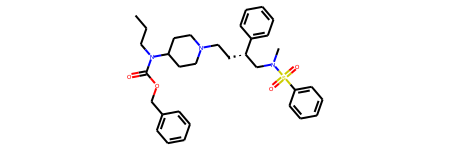

In [27]:
# 1
get_mol("CCCN(C(=O)OCc1ccccc1)C1CCN(CC1)CC[C@H](c1ccccc1)CN(S(=O)(=O)c1ccccc1)C")

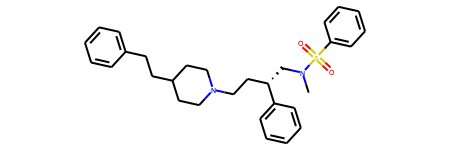

In [30]:
# 2
get_mol("CN(S(=O)(=O)c1ccccc1)C[C@H](c1ccccc1)CCN1CCC(CC1)CCc1ccccc1")

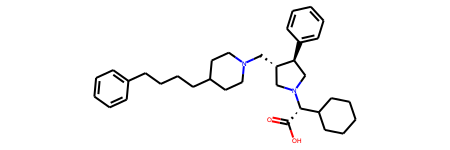

In [31]:
# 3
get_mol("OC(=O)[C@H](N1C[C@@H]([C@H](C1)c1ccccc1)CN1CCC(CC1)CCCCc1ccccc1)C1CCCCC1")

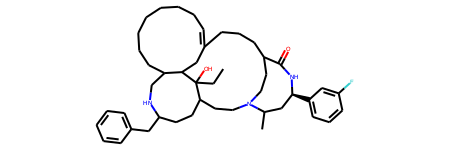

In [20]:
# 4
get_mol("CCC1(O)C2CCC(NCC3C1CC(=CCCCCCCC3)CCCC1CCN(CC2)C(C)C[C@@H](NC1=O)c1cccc(c1)F)Cc1ccccc1")

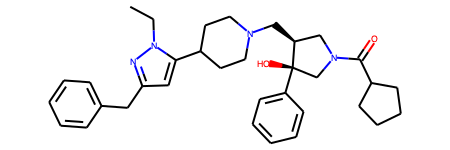

In [22]:
# 5
get_mol("CCn1nc(cc1C1CCN(CC1)C[C@H]1CN(C[C@]1(O)c1ccccc1)C(=O)C1CCCC1)Cc1ccccc1")